In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    preprocessing_function=to_grayscale_then_rgb,
    validation_split=0.25)

train_generator = train_datagen.flow_from_directory(
    r"ASD\Augmented",
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    r"ASD\Augmented", # same directory as training data
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary',
    subset='validation') # set as validation data

Found 1913 images belonging to 2 classes.
Found 637 images belonging to 2 classes.


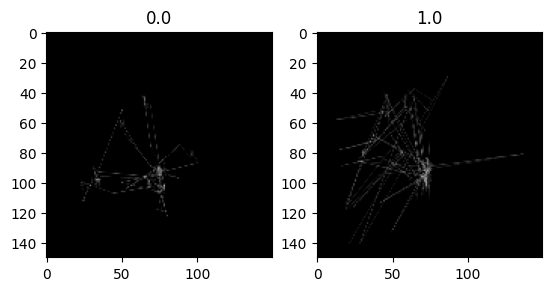

In [4]:
images, labels = next(train_generator)
fig, axes = plt.subplots(1, 2)
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(labels[i])
# show the figure
plt.show()

In [7]:
##Defining the Network 
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation ='relu', input_shape=[150,150,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation ='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation ='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.25))
cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units= 256, activation = 'relu'))
cnn.add(tf.keras.layers.Dropout(0.1))
cnn.add(tf.keras.layers.Dense(units= 128, activation = 'relu'))
cnn.add(tf.keras.layers.Dropout(0.2))

cnn.add(tf.keras.layers.Dense(units= 64, activation = 'relu'))
cnn.add(tf.keras.layers.Dropout(0.2))

cnn.add(tf.keras.layers.Dense(units= 1, activation = 'sigmoid'))
##softmax
from tensorflow.keras.metrics import  Precision, Recall, AUC, Accuracy, binary_focal_crossentropy

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
cnn.compile(optimizer = opt, loss = 'binary_focal_crossentropy', metrics = ['accuracy'])

In [9]:
history = cnn.fit(train_generator, validation_data=validation_generator, epochs = 8)

Epoch 1/8
 38/120 [========>.....................] - ETA: 18s - loss: 0.0872 - accuracy: 0.8618

KeyboardInterrupt: 

40/40 [==============================] - 4s 107ms/step
[[258 119]
 [173  87]]


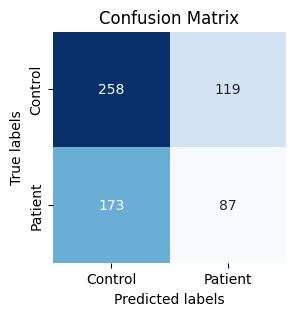

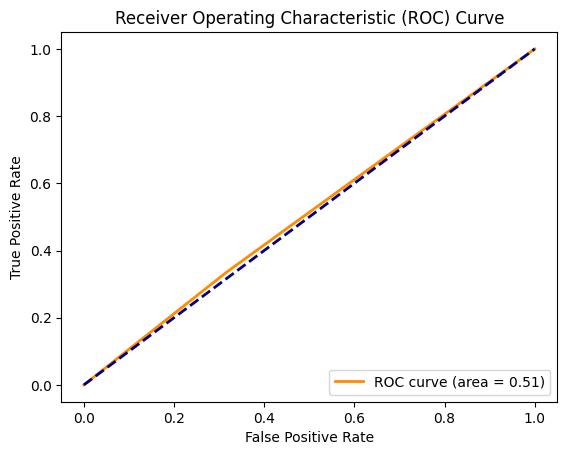

In [10]:
##Confusion Matrix Generator and ROC Curve
y_pred_real = cnn.predict(validation_generator)


In [ ]:

y_pred = [int(p >= 0.5) for p in y_pred_real] ##With sigmoid 1 neuron
##y_pred = np.argmax(Y_pred, axis=1) ##With softmax and 2 neurons 

y_true = validation_generator.classes
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
print(cm)
# Define the class labels
class_names = validation_generator.class_indices.keys()
import seaborn as sns
# Plot the confusion matrix as an image
fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

# Calculate the ROC curve and AUC score, sklearn takes probabilities instead of classes
fpr, tpr, thresholds = roc_curve(y_true, y_pred_real)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
